# Imports

In [1]:
# Python standard library
from collections import defaultdict
import glob
import os

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import screed

# Local python files
from path_constants import (
    FIGURE_FOLDER,
    DATA_FOLDER,
    MAMMALIA_BUSCO_SUBSET_FOLDER,
    ORPHEUM_BENCHMARKING_FOLDER,
)
from nb_utils import describe
from plot_constants import (
    PROTEIN_COLOR,
    DAYHOFF_COLOR,
    PEPTIDE_MOLTYPE_PALETTE,
    PEPTIDE_MOLTYPE_ORDER,
    PEPTIDE_ALPHABET_KSIZES,
    PEPTIDE_ALPHABET_PALETTES,
)
from mya_utils import (
    clean_common_names_of_species,
    BUSCO_MAMMALIA_SPECIES,
    MYA_COLOR_KWARGS,
    MYA_ORDER,
)

## Get number of protein sequences per species

In [2]:
proteome_folder = MAMMALIA_BUSCO_SUBSET_FOLDER

busco_mammalia_species = BUSCO_MAMMALIA_SPECIES.copy()

col = "proteome_size"
busco_mammalia_species[col] = 0
for fasta in glob.glob(os.path.join(proteome_folder, "*.fasta")):
    species_lower = os.path.basename(fasta).split("__")[-1].split(".")[0]
    proteome_size = sum(1 for _ in screed.open(fasta))

    busco_mammalia_species.loc[species_lower, col] = proteome_size
busco_mammalia_species = busco_mammalia_species.sort_values("mya")
describe(busco_mammalia_species)

(18, 4)
--- First 5 entries ---


,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.0,15066
macaca_mulatta,macaque,Macaca mulatta,29.4,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.2,7261
tupaia_chinensis,tupaia,Tupaia chinensis,82.0,1338
mus_musculus,house mouse,Mus musculus,90.0,14519


## Reindex BUSCO mammalia series to use common name

In [3]:
busco_mammalia_common = busco_mammalia_species.reset_index().set_index("common_name")

## Read scikit-learn metrics

In [4]:
alphabet_to_size = {
    'protein': 20,
    'dayhoff': 6
}

In [5]:
csv = os.path.join(
    ORPHEUM_BENCHMARKING_FOLDER, "busco_mammalia_coding_scores_metrics.csv"
)


combined_metrics = pd.read_csv(csv)
combined_metrics.species = combined_metrics.species.map(clean_common_names_of_species)
combined_metrics["proteome"] = combined_metrics["species"]
combined_metrics = combined_metrics.join(busco_mammalia_common, on="species")
combined_metrics["alphabet_ksize"] = combined_metrics.apply(
    lambda x: f"{x.alphabet} ({alphabet_to_size[x.alphabet]}-letter), ksize = {x.ksize}",
    axis=1,
)
describe(combined_metrics)

(6804, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
0,baiji,dayhoff,5,0.004769,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8,"dayhoff (6-letter), ksize = 5"
1,baiji,dayhoff,6,0.000085,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8,"dayhoff (6-letter), ksize = 6"
2,baiji,dayhoff,7,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8,"dayhoff (6-letter), ksize = 7"
3,baiji,dayhoff,8,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8,"dayhoff (6-letter), ksize = 8"
4,baiji,dayhoff,9,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8,"dayhoff (6-letter), ksize = 9"


## Subset to only Precision and Recall, Dayhoff k=17 and protein k=8

In [6]:
precision_recall_score_names =  'precision_score', 'recall_score'

combined_metrics_precision_recall = combined_metrics.query(
    '(score_name in @precision_recall_score_names) and '
    '(((alphabet == "protein") and (ksize == 8)) or '
    '((alphabet == "dayhoff") and (ksize == 17))) '
    ' and proteome_size > 4000'
)
describe(combined_metrics_precision_recall)

(24, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
3252,hedgehog,dayhoff,17,0.999678,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448,"dayhoff (6-letter), ksize = 17"
3270,hedgehog,protein,8,1.000000,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448,"protein (20-letter), ksize = 8"
3306,human,dayhoff,17,0.998971,precision_score,human,homo_sapiens,Homo sapiens,0.0,15066,"dayhoff (6-letter), ksize = 17"
3324,human,protein,8,0.999017,precision_score,human,homo_sapiens,Homo sapiens,0.0,15066,"protein (20-letter), ksize = 8"
3414,macaque,dayhoff,17,0.999666,precision_score,macaque,macaca_mulatta,Macaca mulatta,29.4,5008,"dayhoff (6-letter), ksize = 17"


# Fig 2E, F

## @paper - precision, recall F1 for best ksizes of dayhoff and protein

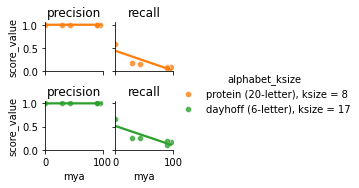

In [7]:
g = sns.lmplot(
    data=combined_metrics_precision_recall,
    x="mya",
    y="score_value",
    col="score_name",
    #     col_wrap=3,
    row="alphabet",
    row_order=["protein", "dayhoff"],
    height=1.25,
    hue="alphabet_ksize",
    #     lowess=True,
    scatter_kws=dict(linewidth=0.5, edgecolor="white"),
    ci=False,
    hue_order=["protein (20-letter), ksize = 8", "dayhoff (6-letter), ksize = 17"],
    palette=[PROTEIN_COLOR, DAYHOFF_COLOR],
)
g.set_titles("{col_name}")
g.set(ylim=(0, 1.05), yticks=[0, 0.5, 1], xlim=(0, 100))
g.set_xlabels("mya")
for ax in g.axes.flat:
    title = ax.get_title()
    new_title = title.split("_score")[0]
    ax.set(title=new_title)

pdf = os.path.join(
    FIGURE_FOLDER,
    "orpheum_translate__human_mouse__precision_recall_f12__protein-k8__dayhoff-k17.pdf",
)
g.savefig(pdf)